##Setup and Installation

In [ ]:
!pip install ultralytics

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving plastics_filtered.zip to plastics_filtered.zip


## Dataset Extraction

In [ ]:
import zipfile
import os

zip_path = '/content/plastics_filtered.zip'
extract_path = '/content/dataset'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction complete!")


✅ Extraction complete!


##Reading data.yaml Configuration File

In [ ]:
import yaml


yaml_path = '/content/dataset/plastics_filtered/data.yaml'

# Read and print the YAML contents
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

print("📄 Contents of data.yaml:\n")
print(data)

📄 Contents of data.yaml:

{'names': ['Mask', 'pbag', 'pbottle'], 'nc': 3, 'test': '../test/images', 'train': '../train/images', 'val': '../valid/images'}


##Data Verification

In [ ]:
import os
import glob

def check_image_label_pairs(dataset_path):
    """
    Checks if every image has a corresponding label file and vice versa.
    """

    # Define image and label directories
    image_dir = os.path.join(dataset_path, 'images')
    label_dir = os.path.join(dataset_path, 'labels')

    # Collect image and label file names (without extensions)
    image_files = glob.glob(os.path.join(image_dir, '*.jpg')) + glob.glob(os.path.join(image_dir, '*.png'))
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))

    image_names = {os.path.splitext(os.path.basename(f))[0] for f in image_files}
    label_names = {os.path.splitext(os.path.basename(f))[0] for f in label_files}

    # Find mismatches
    missing_labels = image_names - label_names
    missing_images = label_names - image_names

    # Print summary
    print(f"📁 Dataset Path: {dataset_path}")
    print(f"🖼 Total images found: {len(image_files)}")
    print(f"📝 Total label files found: {len(label_files)}")
    print(f"❌ Images without labels: {len(missing_labels)}")
    print(f"❌ Labels without images: {len(missing_images)}")

    # Optional: list few examples
    if missing_labels:
        print("\n🖼 Images missing labels (first 10):")
        print(list(missing_labels)[:10])
    if missing_images:
        print("\n📝 Labels missing images (first 10):")
        print(list(missing_images)[:10])

    return missing_labels, missing_images

In [ ]:
missing_labels, missing_images = check_image_label_pairs('/content/dataset/plastics_filtered')

📁 Dataset Path: /content/dataset/plastics_filtered
🖼 Total images found: 0
📝 Total label files found: 0
❌ Images without labels: 0
❌ Labels without images: 0


In [ ]:
import yaml
import matplotlib.pyplot as plt
from collections import Counter
import cv2
import random

yaml_path = '/content/dataset/plastics_filtered/data.yaml'

with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# Extract class names
class_names = data['names']
print("✅ Classes found:", class_names)


✅ Classes found: ['Mask', 'pbag', 'pbottle']


##Class Distribution (Before Balancing)

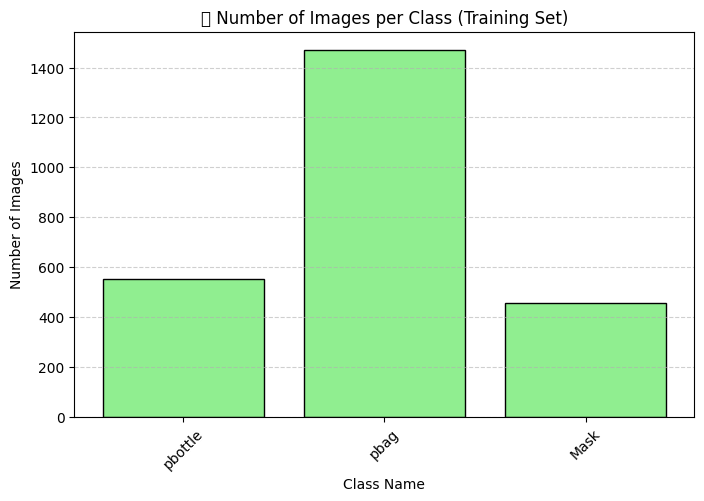

{'pbottle': 553, 'pbag': 1470, 'Mask': 456}

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
from collections import defaultdict
import yaml

def plot_class_distribution_train(dataset_path, yaml_path):
    """
    Plots the number of images containing each class in the training set.
    """

    # Load class names from data.yaml
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    class_names = data['names']

    # Path to training labels
    label_path = os.path.join(dataset_path, 'train/labels')
    label_files = glob.glob(os.path.join(label_path, '*.txt'))

    # Count how many images contain each class
    class_to_images = defaultdict(set)
    for file in label_files:
        image_id = os.path.splitext(os.path.basename(file))[0]
        with open(file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) > 0:
                    cls_id = int(parts[0])
                    class_to_images[cls_id].add(image_id)

    # Prepare data for plotting
    class_counts = {class_names[i]: len(imgs) for i, imgs in class_to_images.items()}

    # Plot
    plt.figure(figsize=(8,5))
    plt.bar(class_counts.keys(), class_counts.values(), color='lightgreen', edgecolor='black')
    plt.title("📊 Number of Images per Class (Training Set)")
    plt.xlabel("Class Name")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

    return class_counts

# === Run for your dataset ===
plot_class_distribution_train(
    dataset_path='/content/dataset/plastics_filtered',
    yaml_path='/content/dataset/plastics_filtered/data.yaml'
)


## Data Balancing and Augmentation


In [ ]:
import random
import shutil
from PIL import Image, ImageOps, ImageEnhance
from tqdm import tqdm

# === Paths ===
base_path = '/content/dataset/plastics_filtered'
train_images_dir = os.path.join(base_path, 'train/images')
train_labels_dir = os.path.join(base_path, 'train/labels')

# Output path (new balanced folder)
output_images_dir = os.path.join(base_path, 'train_balanced/images')
output_labels_dir = os.path.join(base_path, 'train_balanced/labels')
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# === Desired number of images per class ===
TARGET = 650

# === Helper function: Augmentation ===
def augment_image(img_path, output_dir, aug_name):
    """Simple augmentations: flip, rotate, brightness."""
    img = Image.open(img_path)

    if random.random() > 0.5:
        img = ImageOps.mirror(img)  # horizontal flip
    if random.random() > 0.5:
        img = img.rotate(random.choice([90, 180, 270]))
    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(random.uniform(0.7, 1.3))

    aug_path = os.path.join(output_dir, f"{aug_name}.jpg")
    img.save(aug_path, quality=95)

# === Step 1: Group images by class ===
class_to_images = defaultdict(list)
for lbl_file in glob.glob(os.path.join(train_labels_dir, '*.txt')):
    with open(lbl_file, 'r') as f:
        lines = f.readlines()
        if not lines:
            continue
        cls_id = int(lines[0].split()[0])  # assumes one class per image
        class_to_images[cls_id].append(os.path.splitext(os.path.basename(lbl_file))[0])

print("📊 Class distribution before balancing:")
for cls, imgs in class_to_images.items():
    print(f"Class {cls}: {len(imgs)} images")

# === Step 2: Create balanced dataset ===
for cls_id, images in class_to_images.items():
    print(f"\n⚙️ Processing class {cls_id} ...")
    if len(images) >= TARGET:
        # Randomly select TARGET images
        selected = random.sample(images, TARGET)
    else:
        selected = images.copy()

    # Copy selected images
    for name in selected:
        img_src = os.path.join(train_images_dir, f"{name}.jpg")
        lbl_src = os.path.join(train_labels_dir, f"{name}.txt")
        if os.path.exists(img_src) and os.path.exists(lbl_src):
            shutil.copy(img_src, output_images_dir)
            shutil.copy(lbl_src, output_labels_dir)

    # Augment if needed
    if len(images) < TARGET:
        needed = TARGET - len(images)
        augment_candidates = random.choices(images, k=needed)
        for name in tqdm(augment_candidates, desc=f"Augmenting class {cls_id}"):
            img_src = os.path.join(train_images_dir, f"{name}.jpg")
            lbl_src = os.path.join(train_labels_dir, f"{name}.txt")

            aug_name = f"{name}_aug{random.randint(0,9999)}"
            augment_image(img_src, output_images_dir, aug_name)
            shutil.copy(lbl_src, os.path.join(output_labels_dir, f"{aug_name}.txt"))

print("\n✅ Balancing complete!")
print(f"Saved to:\n{output_images_dir}\n{output_labels_dir}")

📊 Class distribution before balancing:
Class 2: 535 images
Class 1: 1450 images
Class 0: 456 images

⚙️ Processing class 2 ...


Augmenting class 2: 100%|██████████| 115/115 [00:00<00:00, 139.72it/s]



⚙️ Processing class 1 ...

⚙️ Processing class 0 ...


Augmenting class 0: 100%|██████████| 194/194 [00:00<00:00, 309.47it/s]


✅ Balancing complete!
Saved to:
/content/dataset/plastics_filtered/train_balanced/images
/content/dataset/plastics_filtered/train_balanced/labels


## Visualizing Class Distribution (After Balancing)



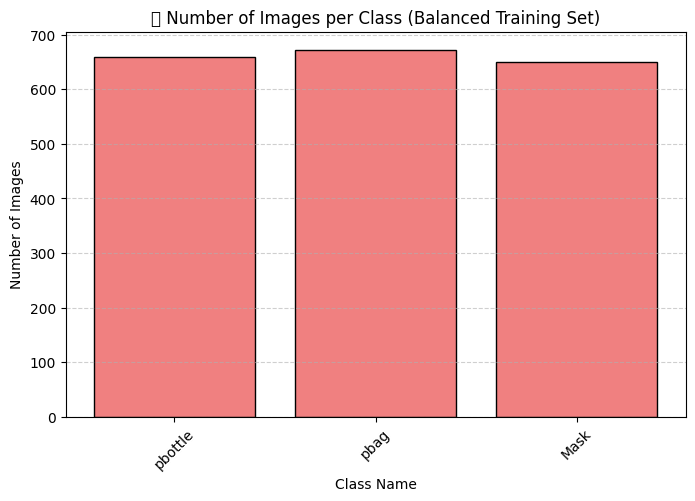


✅ Class Counts in Balanced Dataset:
{'pbottle': 660, 'pbag': 672, 'Mask': 650}


In [ ]:
import os, glob, yaml, matplotlib.pyplot as plt
from collections import defaultdict

def plot_class_distribution_balanced(dataset_path, yaml_path):
    """
    Plots the number of images containing each class in the *balanced* training set.
    """
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    class_names = data['names']

    label_path = os.path.join(dataset_path, 'train_balanced/labels')
    label_files = glob.glob(os.path.join(label_path, '*.txt'))

    class_to_images = defaultdict(set)
    for file in label_files:
        image_id = os.path.splitext(os.path.basename(file))[0]
        with open(file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) > 0:
                    cls_id = int(parts[0])
                    class_to_images[cls_id].add(image_id)

    class_counts = {class_names[i]: len(imgs) for i, imgs in class_to_images.items()}

    plt.figure(figsize=(8,5))
    plt.bar(class_counts.keys(), class_counts.values(), color='lightcoral', edgecolor='black')
    plt.title("📊 Number of Images per Class (Balanced Training Set)")
    plt.xlabel("Class Name")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

    print("\n✅ Class Counts in Balanced Dataset:")
    print(class_counts)

# === Run for your balanced dataset ===
plot_class_distribution_balanced(
    dataset_path='/content/dataset/plastics_filtered',
    yaml_path='/content/dataset/plastics_filtered/data.yaml'
)

## Model Training (YOLOv8 Nano, Medium, Large)

In [ ]:
from ultralytics import YOLO
import os
import torch

# === Common Training Parameters ===
DATA_YAML = "/content/dataset/plastics_filtered/data.yaml"
EPOCHS = 25          # same for fairness
IMGSZ = 640          # same input size for all
PROJECT_DIR = "/content/AI_Project"

# === Create Base Folder Structure ===
if not os.path.exists(PROJECT_DIR):
    os.makedirs(PROJECT_DIR)
    print(f"📁 Created base project folder: {PROJECT_DIR}")
else:
    print(f"📁 Base project folder already exists: {PROJECT_DIR}")

subfolders = {
    "Nano": os.path.join(PROJECT_DIR, "YOLOv8_Nano"),
    "Medium": os.path.join(PROJECT_DIR, "YOLOv8_Medium"),
    "Large": os.path.join(PROJECT_DIR, "YOLOv8_Large")
}
for name, path in subfolders.items():
    os.makedirs(path, exist_ok=True)
    print(f"  └─ Created subfolder for {name}: {path}")

# === Define Training Helper Function ===
def train_model(model_name, weights, project_path, batch_size):
    print(f"\n🚀 Training {model_name} ...")
    torch.cuda.empty_cache()   # clear GPU memory between models
    model = YOLO(weights)
    try:
        model.train(
            data=DATA_YAML,
            epochs=EPOCHS,
            imgsz=IMGSZ,
            batch=batch_size,
            project=project_path,
            name=f"{model_name.lower()}_plastics_balanced",
            amp=True,
            exist_ok=True,
            cache=False
        )
        print(f"✅ {model_name} training completed successfully!\n")
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print(f"❌ OOM Error in {model_name}: Try reducing batch size (current={batch_size})")
        else:
            print(f"⚠️ Unexpected error while training {model_name}: {e}")

# === Train Each Model ===
train_model("YOLOv8-Nano", "yolov8n.pt", subfolders["Nano"], batch_size=32)
train_model("YOLOv8-Medium", "yolov8m.pt", subfolders["Medium"], batch_size=16)
train_model("YOLOv8-Large", "yolov8l.pt", subfolders["Large"], batch_size=8)

print("\n✅ All models trained (or attempted) successfully!")
print("📦 Organized in:")
for name, path in subfolders.items():
    print(f"   - {name}: {path}")


📁 Created base project folder: /content/AI_Project
  └─ Created subfolder for Nano: /content/AI_Project/YOLOv8_Nano
  └─ Created subfolder for Medium: /content/AI_Project/YOLOv8_Medium
  └─ Created subfolder for Large: /content/AI_Project/YOLOv8_Large

🚀 Training YOLOv8-Nano ...
Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/plastics_filtered/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, 

## Training Performance Comparison (mAP Across Epochs)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


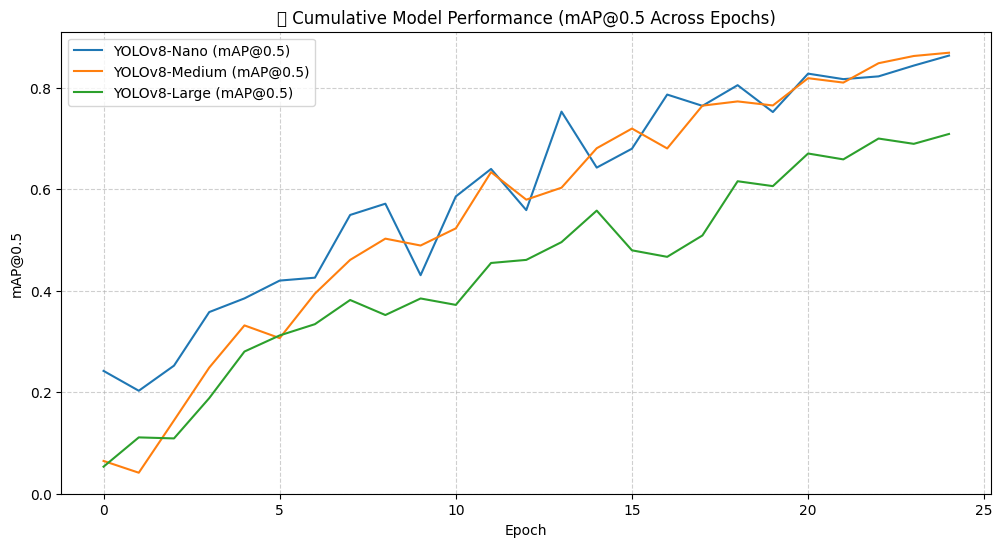

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to your results.csv files
results_paths = {
    "YOLOv8-Nano": "/content/AI_Project/YOLOv8_Nano/yolov8-nano_plastics_balanced/results.csv",
    "YOLOv8-Medium": "/content/AI_Project/YOLOv8_Medium/yolov8-medium_plastics_balanced/results.csv",
    "YOLOv8-Large": "/content/AI_Project/YOLOv8_Large/yolov8-large_plastics_balanced/results.csv"
}

# Read results
plt.figure(figsize=(12,6))
for model_name, path in results_paths.items():
    df = pd.read_csv(path)
    if "metrics/mAP50(B)" in df.columns:
        plt.plot(df.index, df["metrics/mAP50(B)"], label=f"{model_name} (mAP@0.5)")
    else:
        print(f"⚠️ mAP column not found in {path}")

plt.title("📈 Cumulative Model Performance (mAP@0.5 Across Epochs)")
plt.xlabel("Epoch")
plt.ylabel("mAP@0.5")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


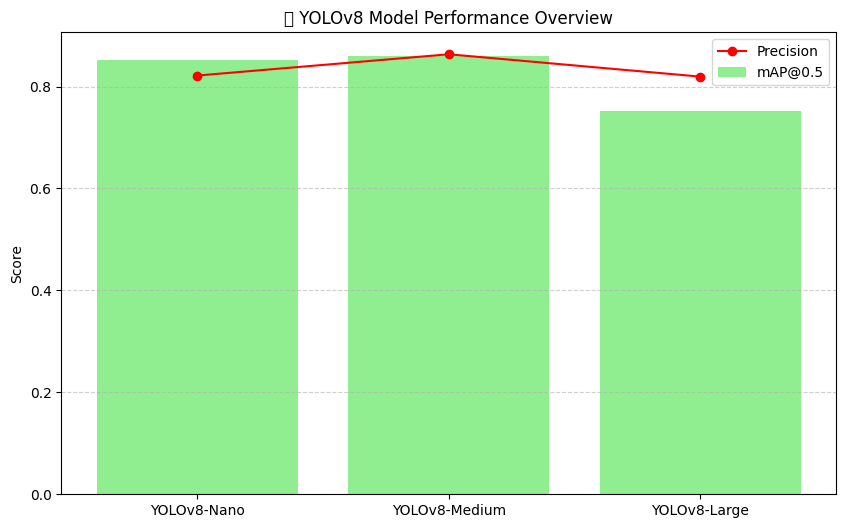

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(df_results.index, df_results["mAP@0.5"], color='lightgreen', label='mAP@0.5')
plt.plot(df_results.index, df_results["Precision"], color='red', marker='o', label='Precision')
plt.ylabel("Score")
plt.title("📊 YOLOv8 Model Performance Overview")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


##Model Testing (Inference on Test Images)

In [ ]:
from ultralytics import YOLO
import os

def test_all_models():
    """
    Runs inference on test images using YOLOv8 Nano, Medium, and Large models.
    Saves predictions in organized folders.
    """

    # === Define model paths (as you provided) ===
    model_paths = {
        "YOLOv8-Nano": "/content/AI_Project/YOLOv8_Nano/yolov8-nano_plastics_balanced/weights/best.pt",
        "YOLOv8-Medium": "/content/AI_Project/YOLOv8_Medium/yolov8-medium_plastics_balanced/weights/best.pt",
        "YOLOv8-Large": "/content/AI_Project/YOLOv8_Large/yolov8-large_plastics_balanced/weights/best.pt"
    }

    # === Test image directory ===
    test_images_dir = "/content/dataset/plastics_filtered/test/images"

    # === Loop through each model and run predictions ===
    for model_name, model_path in model_paths.items():
        if not os.path.exists(model_path):
            print(f"⚠️ {model_name}: File not found → {model_path}")
            continue

        print(f"\n🚀 Running predictions for {model_name} ...")
        model = YOLO(model_path)

        # Save results inside same model folder
        save_dir = os.path.dirname(model_path).replace("weights", "predictions")
        os.makedirs(save_dir, exist_ok=True)

        # Run inference
        model.predict(
            source=test_images_dir,
            name=f"{model_name}_predictions",
            project=save_dir,
            exist_ok=True,
            save=True,
            imgsz=640,
            conf=0.25
        )

        print(f"✅ Predictions saved for {model_name} → {save_dir}\n")

# === Run testing ===
test_all_models()



🚀 Running predictions for YOLOv8-Nano ...

image 1/308 /content/dataset/plastics_filtered/test/images/200623160205-05-coronavirus-waste-pollution-super-169_jpg.rf.e06b1a6873ec4240c3493f281822c9d9.jpg: 640x640 1 Mask, 1 pbottle, 11.9ms
image 2/308 /content/dataset/plastics_filtered/test/images/66b85ac2-5d1b-4783-b0fa-4f8adcda51a5_jpg.rf.33eb90a2198eccbfbc6e7961b953ac4a.jpg: 640x640 4 Masks, 12.9ms
image 3/308 /content/dataset/plastics_filtered/test/images/7_JPG_jpg.rf.3bf999e1c1e0a9a932b23d95b27357dc.jpg: 640x640 1 Mask, 7.3ms
image 4/308 /content/dataset/plastics_filtered/test/images/GettyImages-1227891345-1000x667_jpg.rf.32ae9a5a4e410851af33ae743636ac1a.jpg: 640x640 (no detections), 7.3ms
image 5/308 /content/dataset/plastics_filtered/test/images/GettyImageskl-1227891345-1000x667_jpg.rf.b1b21e076c5e516af46499d92e4d57d8.jpg: 640x640 1 pbag, 7.3ms
image 6/308 /content/dataset/plastics_filtered/test/images/STOCK_DSC8177_3opix2_jpg.rf.e9f5811cd21ce1f2ac92b50c20df9b5d.jpg: 640x640 1 Mask,

## Model Validation Metrics (Precision, Recall, mAP)

In [ ]:
from ultralytics import YOLO

# Paths to your trained models
models = {
    "YOLOv8-Nano": "/content/AI_Project/YOLOv8_Nano/yolov8-nano_plastics_balanced/weights/best.pt",
    "YOLOv8-Medium": "/content/AI_Project/YOLOv8_Medium/yolov8-medium_plastics_balanced/weights/best.pt",
    "YOLOv8-Large": "/content/AI_Project/YOLOv8_Large/yolov8-large_plastics_balanced/weights/best.pt"
}

results_dict = {}

for name, path in models.items():
    print(f"\n📊 Validating {name} ...")
    model = YOLO(path)
    results = model.val(data="/content/dataset/plastics_filtered/data.yaml", split="test")
    results_dict[name] = results.results_dict  # store metrics



📊 Validating YOLOv8-Nano ...
Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 994.6±392.5 MB/s, size: 37.6 KB)
val: Scanning /content/dataset/plastics_filtered/test/labels... 308 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 308/308 837.1it/s 0.4s
val: New cache created: /content/dataset/plastics_filtered/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 88, len(boxes) = 417. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 20/20 4.0it/s 5.0s
                   all        308        417      0.821      0.797      0.852      0.631
                 

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


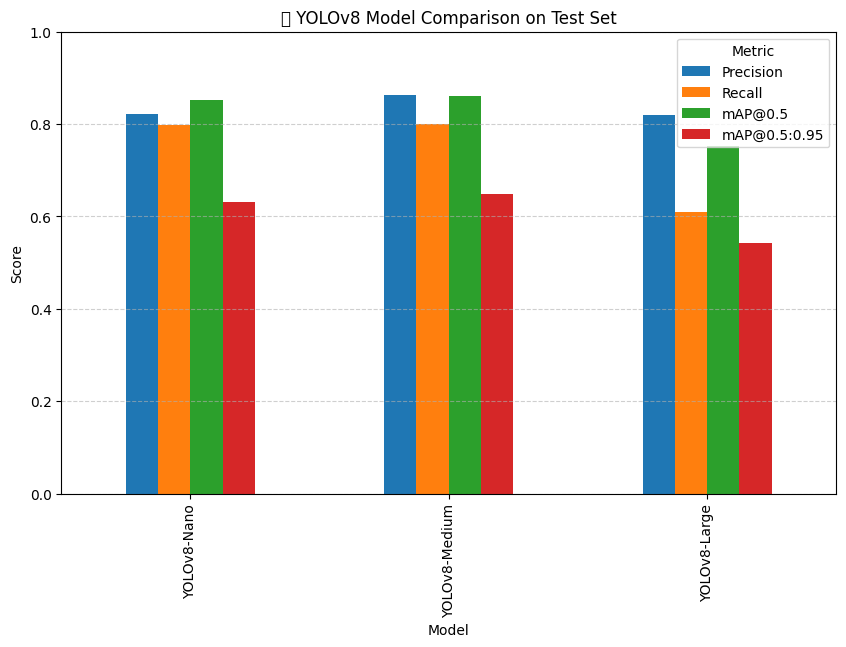


✅ Real Test Set Results:
               Precision    Recall   mAP@0.5  mAP@0.5:0.95
YOLOv8-Nano     0.821437  0.797091  0.851940      0.631271
YOLOv8-Medium   0.863217  0.800917  0.860403      0.649217
YOLOv8-Large    0.819363  0.609471  0.751712      0.541608


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrame
df_results = pd.DataFrame(results_dict).T

# Select key metrics
df_results = df_results[["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]]
df_results.rename(columns={
    "metrics/precision(B)": "Precision",
    "metrics/recall(B)": "Recall",
    "metrics/mAP50(B)": "mAP@0.5",
    "metrics/mAP50-95(B)": "mAP@0.5:0.95"
}, inplace=True)

# Plot all metrics
df_results.plot(kind='bar', figsize=(10,6))
plt.title("📈 YOLOv8 Model Comparison on Test Set")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Metric")
plt.show()

print("\n✅ Real Test Set Results:")
print(df_results)


## Visual Comparison of Predictions



🖼 Random images selected for comparison:
['uwg_g-989_jpg.rf.da26a497658c61d651accee1c840dd9f.jpg', '7_JPG_jpg.rf.3bf999e1c1e0a9a932b23d95b27357dc.jpg', 'vid_000171_frame0000002_jpg.rf.f7c6b00bad49e6203ceb5507c0a9ece4.jpg']


/tmp/ipython-input-2456988931.py:34: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


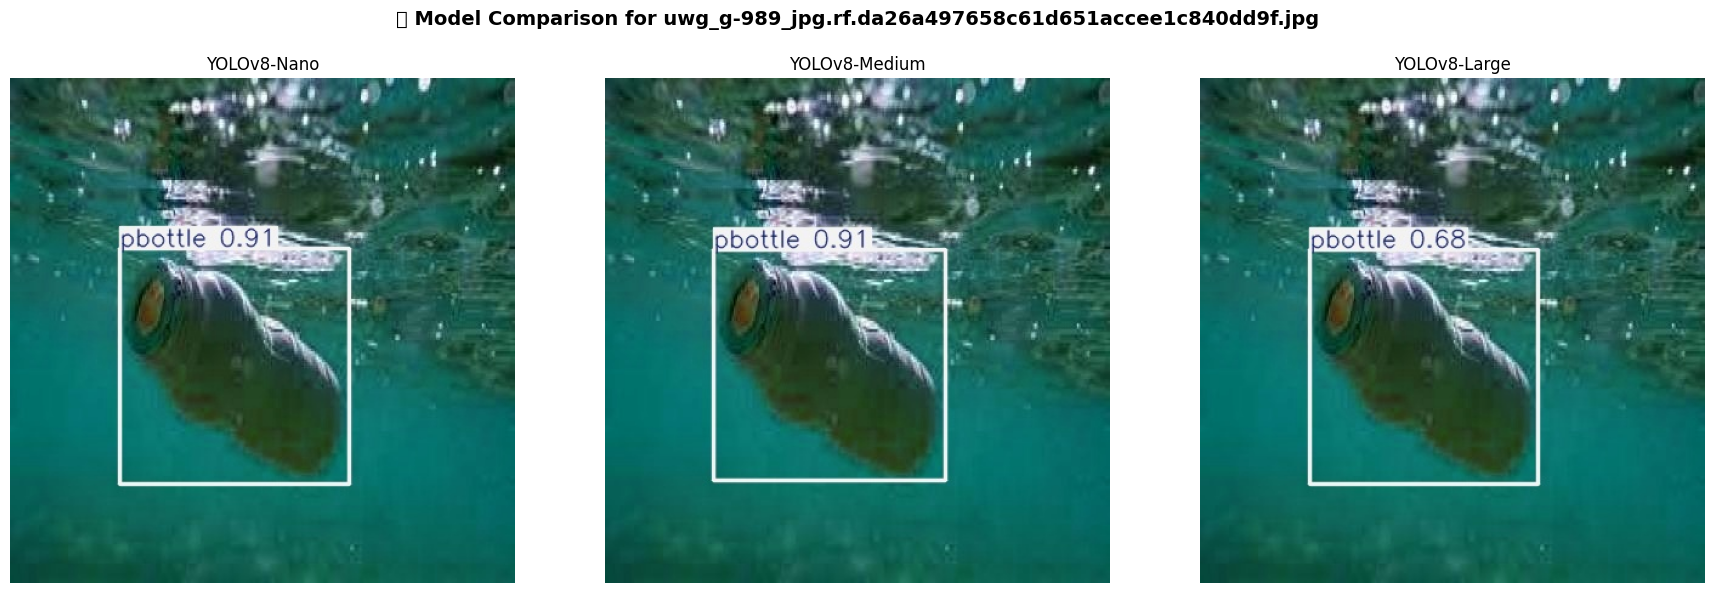

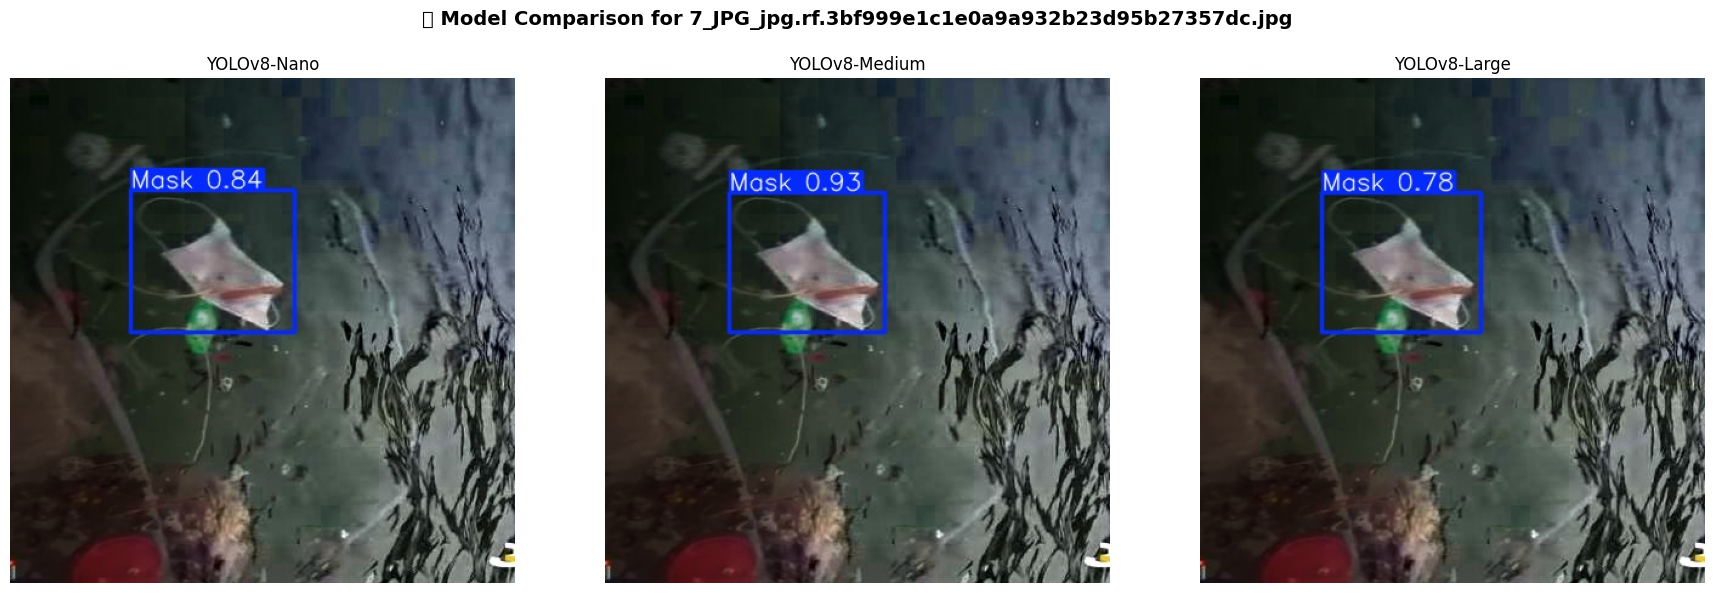

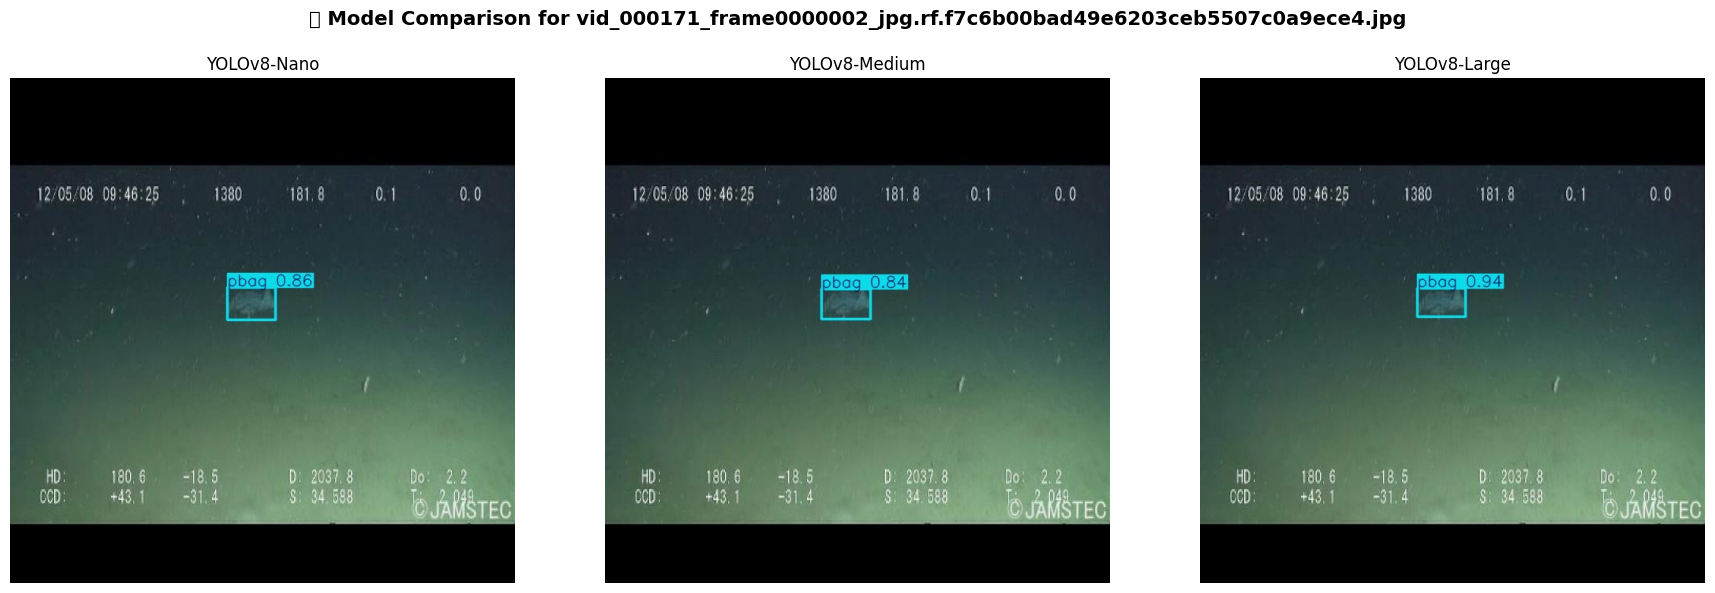

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

prediction_paths = {
    "YOLOv8-Nano": "/content/AI_Project/YOLOv8_Nano/yolov8-nano_plastics_balanced/predictions/YOLOv8-Nano_predictions",
    "YOLOv8-Medium": "/content/AI_Project/YOLOv8_Medium/yolov8-medium_plastics_balanced/predictions/YOLOv8-Medium_predictions",
    "YOLOv8-Large": "/content/AI_Project/YOLOv8_Large/yolov8-large_plastics_balanced/predictions/YOLOv8-Large_predictions"
}

# === Select random test images from Nano folder ===
image_files = [f for f in os.listdir(prediction_paths["YOLOv8-Nano"]) if f.endswith(('.jpg', '.png'))]
num_images = 3
random_images = random.sample(image_files, min(num_images, len(image_files)))
print(f"\n🖼 Random images selected for comparison:\n{random_images}")

# === Display each selected image across all models ===
for img_name in random_images:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"🔍 Model Comparison for {img_name}", fontsize=14, fontweight='bold')

    for ax, (model, path) in zip(axes, prediction_paths.items()):
        img_path = os.path.join(path, img_name)
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(model, fontsize=12)
        else:
            ax.text(0.5, 0.5, "❌ Image Not Found", ha="center", va="center", fontsize=12, color="red")
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
!zip -r AI_PROJECT.zip /content/ -x "/content/sample_data/*"

Streaming output truncated to the last 5000 lines.
  adding: content/dataset/plastics_filtered/train_balanced/labels/uwg_g-1069__fliph_jpg.rf.70410087a743c33febad5a75a401a3d7.txt (deflated 33%)
  adding: content/dataset/plastics_filtered/train_balanced/labels/20211007105131_jpg.rf.0c3b8ca953f51cf4248ce291b812f3c7.txt (deflated 60%)
  adding: content/dataset/plastics_filtered/train_balanced/labels/uwg_g-953__fliph_jpg.rf.fffd5aa3426462be200472e38036a020.txt (deflated 33%)
  adding: content/dataset/plastics_filtered/train_balanced/labels/uwg_g-1117_jpg.rf.9ca7a9a386eba5788a3ed25797ee484f_aug3563.txt (deflated 32%)
  adding: content/dataset/plastics_filtered/train_balanced/labels/photo_71_jpg.rf.a7671b0ccaf091dac04ad4b7fc14803e.txt (deflated 57%)
  adding: content/dataset/plastics_filtered/train_balanced/labels/uwg_g-1056__fliph_jpg.rf.4db488b197a812b1d2c6fa847cac849d.txt (deflated 32%)
  adding: content/dataset/plastics_filtered/train_balanced/labels/photo_6_jpg.rf.5e73ce41327b3229003122

In [ ]:
from google.colab import files
files.download("AI_PROJECT.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>